In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/sme-invoicing-assistant


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/sme-invoicing-assistant/.env


True

In [4]:
results_mapping = {
    "RTX A6000": "results/metrics_RTX A6000.csv",
    "RTX 4090": "results/metrics_RTX 4090.csv",
    "OpenAI": "results/metrics_OpenAI.csv",
}

In [5]:
import pandas as pd

# Initialize an empty DataFrame
metrics_df = pd.DataFrame()

# Process results and populate the DataFrame
for platform, results in results_mapping.items():
    results_df = pd.read_csv(results)
    metrics_df = pd.concat(
        [metrics_df, results_df], ignore_index=True
    )

metrics_df

,platform,model,task_completion_rate,task_success_rate,mean_execution_time,total_tasks,SUCCESS,ERROR,NO_INVOICE,power
0,RTX A6000,qwen2.5_7b,1,0.858586,11.295402,990,850,136,4,288.3550
1,RTX A6000,functionary-small,1,0.884848,1.734658,990,876,6,108,288.3550
2,RTX A6000,qwen2.5_32b,1,0.998990,12.947549,990,989,1,0,299.8840
3,RTX A6000,functionary-medium,1,0.941414,18.798024,990,932,11,47,284.6410
4,RTX A6000,qwen2.5_72b,1,0.994949,68.134819,990,985,4,1,284.6410
5,RTX 4090,qwen2.5_7b,1,0.873737,21.020921,990,865,123,2,121.7782
6,RTX 4090,functionary-small,1,0.887879,3.568125,990,879,10,101,146.6126
7,OpenAI,gpt-4o-mini,1,0.976768,11.385764,990,967,21,2,NaN
8,OpenAI,gpt-4o,1,0.931313,11.128501,990,922,15,53,NaN


In [6]:
metrics_df["Energy per Task (Joules)"] = metrics_df["mean_execution_time"].astype(
    float
) * metrics_df["power"].astype(float)
metrics_df["Performance-to-Power Ratio (%/J)"] = (
    metrics_df["task_success_rate"].astype(float)
    * 100
    / metrics_df["Energy per Task (Joules)"].astype(float)
)
metrics_df

,platform,model,task_completion_rate,task_success_rate,mean_execution_time,total_tasks,SUCCESS,ERROR,NO_INVOICE,power,Energy per Task (Joules),Performance-to-Power Ratio (%/J)
0,RTX A6000,qwen2.5_7b,1,0.858586,11.295402,990,850,136,4,288.3550,3257.085540,0.026361
1,RTX A6000,functionary-small,1,0.884848,1.734658,990,876,6,108,288.3550,500.197347,0.176900
2,RTX A6000,qwen2.5_32b,1,0.998990,12.947549,990,989,1,0,299.8840,3882.762779,0.025729
3,RTX A6000,functionary-medium,1,0.941414,18.798024,990,932,11,47,284.6410,5350.688239,0.017594
4,RTX A6000,qwen2.5_72b,1,0.994949,68.134819,990,985,4,1,284.6410,19393.963069,0.005130
5,RTX 4090,qwen2.5_7b,1,0.873737,21.020921,990,865,123,2,121.7782,2559.889897,0.034132
6,RTX 4090,functionary-small,1,0.887879,3.568125,990,879,10,101,146.6126,523.132146,0.169724
7,OpenAI,gpt-4o-mini,1,0.976768,11.385764,990,967,21,2,NaN,NaN,NaN
8,OpenAI,gpt-4o,1,0.931313,11.128501,990,922,15,53,NaN,NaN,NaN


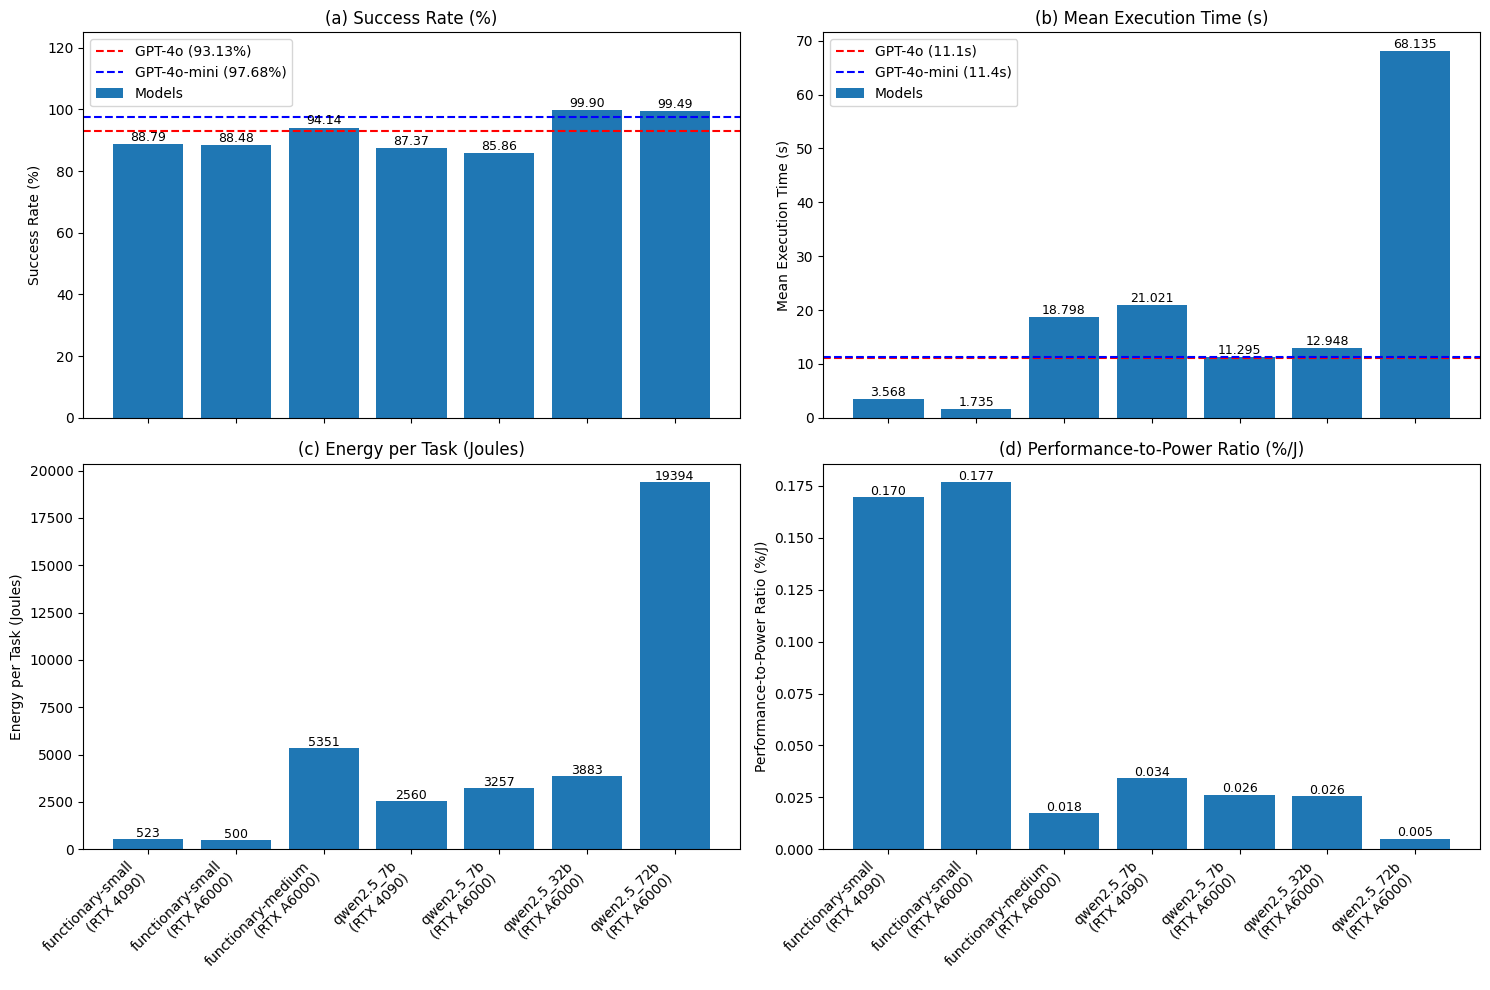

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = metrics_df[:-2].copy()

# Custom order for models by size and platform
model_order = {
    "qwen2.5:7b": 1,
    "functionary-small": 2,
    "qwen2.5:32b": 3,
    "functionary-medium": 4,
    "qwen2.5:72b": 5,
}
df["model_order"] = df["model"].map(model_order)
df["combined"] = df["model"] + "\n(" + df["platform"] + ")"
df = df.sort_values(by=["model_order", "platform"], ascending=[True, True])

# Setting up data for plotting
x_labels = df["combined"]
x_pos = np.arange(len(x_labels))

# Adding horizontal dashed lines for GPT-4o and GPT-4o-mini
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# First subplot: Success Rate
ax[0, 0].bar(
    x_pos, df["task_success_rate"] * 100, label="Models"
)  # Convert to percentage
ax[0, 0].set_title("(a) Success Rate (%)")
ax[0, 0].set_xticks(x_pos)
ax[0, 0].set_xticklabels([])
ax[0, 0].set_ylabel("Success Rate (%)")
ax[0, 0].set_ylim(0, 125)
for i, v in enumerate(df["task_success_rate"] * 100):
    ax[0, 0].text(i, v + 1, f"{v:.2f}", ha="center", fontsize=9)

# Adding horizontal dashed lines for GPT-4o and GPT-4o-mini
gpt_4o_success_rate = (
    metrics_df[metrics_df["model"] == "gpt-4o"].iloc[0]["task_success_rate"] * 100
)
gpt_4o_mini_success_rate = (
    metrics_df[metrics_df["model"] == "gpt-4o-mini"].iloc[0]["task_success_rate"] * 100
)
ax[0, 0].axhline(
    y=gpt_4o_success_rate,
    color="red",
    linestyle="--",
    label=f"GPT-4o ({gpt_4o_success_rate:.2f}%)",
)
ax[0, 0].axhline(
    y=gpt_4o_mini_success_rate,
    color="blue",
    linestyle="--",
    label=f"GPT-4o-mini ({gpt_4o_mini_success_rate:.2f}%)",
)
ax[0, 0].legend(loc="upper left")

# Second subplot: Mean Execution Time
ax[0, 1].bar(x_pos, df["mean_execution_time"], label="Models")
ax[0, 1].set_title("(b) Mean Execution Time (s)")
ax[0, 1].set_xticks(x_pos)
ax[0, 1].set_xticklabels([])
ax[0, 1].set_ylabel("Mean Execution Time (s)")
for i, v in enumerate(df["mean_execution_time"]):
    ax[0, 1].text(i, v + 0.5, f"{v:.3f}", ha="center", fontsize=9)
# Adding horizontal dashed lines for GPT-4o and GPT-4o-mini
gpt_4o_execution_time = metrics_df[metrics_df["model"] == "gpt-4o"].iloc[0][
    "mean_execution_time"
]
gpt_4o_mini_execution_time = metrics_df[metrics_df["model"] == "gpt-4o-mini"].iloc[0][
    "mean_execution_time"
]
ax[0, 1].axhline(
    y=gpt_4o_execution_time,
    color="red",
    linestyle="--",
    label=f"GPT-4o ({gpt_4o_execution_time:.1f}s)",
)
ax[0, 1].axhline(
    y=gpt_4o_mini_execution_time,
    color="blue",
    linestyle="--",
    label=f"GPT-4o-mini ({gpt_4o_mini_execution_time:.1f}s)",
)
ax[0, 1].legend(loc="upper left")

# Third subplot: Energy per Task (no overlay here)
ax[1, 0].bar(x_pos, df["Energy per Task (Joules)"])
ax[1, 0].set_title("(c) Energy per Task (Joules)")
ax[1, 0].set_xticks(x_pos)
ax[1, 0].set_xticklabels(x_labels, rotation=45, ha="right")
ax[1, 0].set_ylabel("Energy per Task (Joules)")
for i, v in enumerate(df["Energy per Task (Joules)"]):
    ax[1, 0].text(i, v + 100, f"{v:.0f}", ha="center", fontsize=9)

# Fourth subplot: Performance-to-Power Ratio (%/J) (no overlay here)
ax[1, 1].bar(x_pos, df["Performance-to-Power Ratio (%/J)"])
ax[1, 1].set_title("(d) Performance-to-Power Ratio (%/J)")
ax[1, 1].set_xticks(x_pos)
ax[1, 1].set_xticklabels(x_labels, rotation=45, ha="right")
ax[1, 1].set_ylabel("Performance-to-Power Ratio (%/J)")
for i, v in enumerate(df["Performance-to-Power Ratio (%/J)"]):
    ax[1, 1].text(i, v + 0.001, f"{v:.3f}", ha="center", fontsize=9)

# Layout adjustments
plt.tight_layout()
plt.show()